<a href="https://colab.research.google.com/github/holstbone/Neural-Networks-NLP-with-RNN/blob/main/A_3_NLP_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A.3 Language Modeling with RNN:


# Andy's Work Continues Here:

In [ ]:
!python --version

Python 3.7.11


## Import packages 

In [ ]:
import datetime
from time import time
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
#tf.get_logger().setLevel('INFO')

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print('The matplotlib version is {}.'.format(mpl.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The keras version is {}.'.format(keras.__version__))
print('The tensorflow version is {}.'.format(tf.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The matplotlib version is 3.2.2.
The numpy version is 1.19.5.
The pandas version is 1.1.5.
The keras version is 2.5.0.
The tensorflow version is 2.5.0.
The seaborn version is 0.11.1.


### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

### Create a Helper Function to Plot Graphs:

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.5.0


### Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-08-01 22:58:53.931387: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0801 22:58:56.129596 139821686294400 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-08-01 22:58:56.136916: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-08-01 22:58:56.220150: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-08-01 22:58:56.296934: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I0801 22:58:56.367182 139821686294400 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GC

In [ ]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Britain begins redeploying some 800 troops toward the restive area south of Baghdad area in a move aimed at freeing up US forces for an assault on insurgent areas north and west of the capital.'
 b'US Federal Reserve officials are growing more confident about the economic outlook. The economy, which grew at a 3.9 per cent annualised rate in the third quarter and is expanding '
 b'26 August 2004 -- Iraq #39;s top Shi #39;ite cleric, Grand Ayatollah Ali al-Sistani, arrived in the city of Al-Najaf today in a bid to end a weeks-long conflict between US forces and militiamen loyal to Shi #39;ite cleric Muqtada al-Sadr.']

labels:  [0 2 0]
texts:  [b'President Thabo Mbeki took his peace mission to Ivory Coast #39;s rebel-held stronghold of Bouake today, where he was greeted by hundreds of people demanding Laurent Gbagbo, the president, quit.'
 b'Reuters - Global handset sales rose to record\\levels in the second quarter, putting the industry on track to\\ship 650 million cell phon

# RELOAD

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 66,   1,   1, 309,  24, 452,   1,   4,   1, 815,  11,   1,   1,
          5,   1,  78, 289,  36,  27,   1,  18, 828,   5,  80,   1,   1,
          1,   2,  66,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 28, 299,   1, 138, 240,   4,   1,   6,   2, 10

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'President Thabo Mbeki took his peace mission to Ivory Coast #39;s rebel-held stronghold of Bouake today, where he was greeted by hundreds of people demanding Laurent Gbagbo, the president, quit.'
Round-trip:  president [UNK] [UNK] took his peace [UNK] to [UNK] coast 39s [UNK] [UNK] of [UNK] today where he was [UNK] by hundreds of people [UNK] [UNK] [UNK] the president [UNK]                                                                                                                                          

Original:  b'Reuters - Global handset sales rose to record\\levels in the second quarter, putting the industry on track to\\ship 650 million cell phones in 2004 as market leader Nokia\\halted its decline, a survey said on Thursday.'
Round-trip:  reuters global [UNK] sales rose to [UNK] in the second quarter [UNK] the industry on [UNK] [UNK] [UNK] million cell phones in 2004 as market leader [UNK] its [UNK] a survey said on thursday                                    

# **EXPERIMENT 10 - Single Layer Bidirectional LSTM Output Dim 64**

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time()

history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 51s 21ms/step - loss: 0.7225 - accuracy: 0.7175 - val_loss: 0.4863 - val_accuracy: 0.8327
Epoch 2/200
1782/1782 [==============================] - 35s 20ms/step - loss: 0.4676 - accuracy: 0.8332 - val_loss: 0.4500 - val_accuracy: 0.8465
Epoch 3/200
1782/1782 [==============================] - 35s 20ms/step - loss: 0.4371 - accuracy: 0.8424 - val_loss: 0.4325 - val_accuracy: 0.8485
Epoch 4/200
1782/1782 [==============================] - 34s 19ms/step - loss: 0.4159 - accuracy: 0.8494 - val_loss: 0.4114 - val_accuracy: 0.8540
Epoch 5/200
1782/1782 [==============================] - 34s 19ms/step - loss: 0.4010 - accuracy: 0.8549 - val_loss: 0.4047 - val_accuracy: 0.8537
Epoch 6/200
1782/1782 [==============================] - 35s 20ms/step - loss: 0.3901 - accuracy: 0.8579 - val_loss: 0.3959 - val_accuracy: 0.8597
Epoch 7/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.3839 - accuracy: 0.8606 - val_loss: 0

In [ ]:
model_time

362.1248519420624

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 11ms/step - loss: 0.4130 - accuracy: 0.8474
Test Loss: 0.4129798710346222
Test Accuracy: 0.8473684191703796


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.722,0.718,0.486,0.833
1,0.468,0.833,0.450,0.846
2,0.437,0.842,0.433,0.849
3,0.416,0.849,0.411,0.854
4,0.401,0.855,0.405,0.854
5,0.390,0.858,0.396,0.860
6,0.384,0.861,0.395,0.859
7,0.379,0.864,0.397,0.858


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

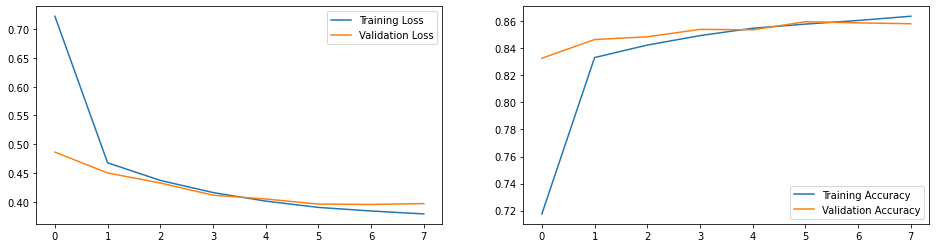

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.33%,99.79%,0.31%,0.77%,99.71%,0.70%,0.56%,20.54%,79.41%,2.06%,99.98%,0.48%,0.57%,82.52%,99.51%
Sports,99.52%,0.01%,0.01%,99.05%,0.02%,0.16%,99.11%,74.92%,1.73%,0.04%,0.00%,0.68%,0.03%,2.23%,0.00%
Business,0.08%,0.17%,2.89%,0.06%,0.08%,9.66%,0.08%,0.36%,2.45%,71.98%,0.02%,0.70%,98.12%,3.22%,0.10%
Sci/Tech,0.07%,0.03%,96.79%,0.12%,0.19%,89.48%,0.25%,4.18%,16.41%,25.92%,0.01%,98.14%,1.28%,12.03%,0.39%


## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


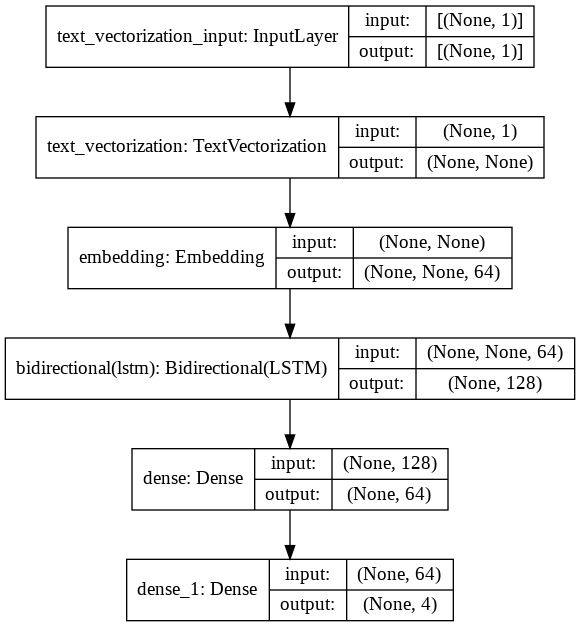

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 11 - Single Layer Bidirectional LSTM Output Dim 128**

## Create the model

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=128
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

## Compile Model 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

## Train the model

In [ ]:
start = time()

history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 50s 24ms/step - loss: 0.6959 - accuracy: 0.7324 - val_loss: 0.4694 - val_accuracy: 0.8413
Epoch 2/200
1782/1782 [==============================] - 40s 23ms/step - loss: 0.4394 - accuracy: 0.8449 - val_loss: 0.4104 - val_accuracy: 0.8595
Epoch 3/200
1782/1782 [==============================] - 39s 22ms/step - loss: 0.4050 - accuracy: 0.8543 - val_loss: 0.3958 - val_accuracy: 0.8572
Epoch 4/200
1782/1782 [==============================] - 39s 22ms/step - loss: 0.3906 - accuracy: 0.8585 - val_loss: 0.3921 - val_accuracy: 0.8597
Epoch 5/200
1782/1782 [==============================] - 40s 22ms/step - loss: 0.3828 - accuracy: 0.8602 - val_loss: 0.3815 - val_accuracy: 0.8653
Epoch 6/200
1782/1782 [==============================] - 38s 21ms/step - loss: 0.3769 - accuracy: 0.8626 - val_loss: 0.3873 - val_accuracy: 0.8598
Epoch 7/200
1782/1782 [==============================] - 39s 22ms/step - loss: 0.3723 - accuracy: 0.8638 - val_loss: 0

In [ ]:
model_time

294.33560156822205

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 10ms/step - loss: 0.3976 - accuracy: 0.8521
Test Loss: 0.39764273166656494
Test Accuracy: 0.8521052598953247


## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.696,0.732,0.469,0.841
1,0.439,0.845,0.410,0.859
2,0.405,0.854,0.396,0.857
3,0.391,0.858,0.392,0.860
4,0.383,0.860,0.382,0.865
5,0.377,0.863,0.387,0.860
6,0.372,0.864,0.383,0.865


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

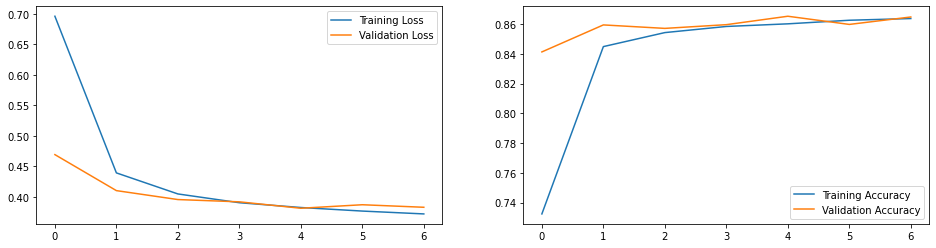

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.08%,99.90%,0.09%,0.39%,99.48%,0.41%,0.49%,29.02%,89.64%,1.90%,99.96%,0.32%,0.88%,86.08%,99.47%
Sports,99.86%,0.00%,0.01%,99.49%,0.02%,0.12%,99.33%,67.30%,0.45%,0.04%,0.00%,0.40%,0.04%,1.56%,0.00%
Business,0.04%,0.07%,4.54%,0.08%,0.22%,14.78%,0.06%,0.31%,1.99%,76.98%,0.02%,1.40%,98.23%,3.70%,0.21%
Sci/Tech,0.02%,0.03%,95.37%,0.05%,0.28%,84.69%,0.12%,3.37%,7.91%,21.08%,0.02%,97.87%,0.85%,8.67%,0.32%


## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 407,876
Trainable params: 407,876
Non-trainable params: 0
_________________________________________________________________


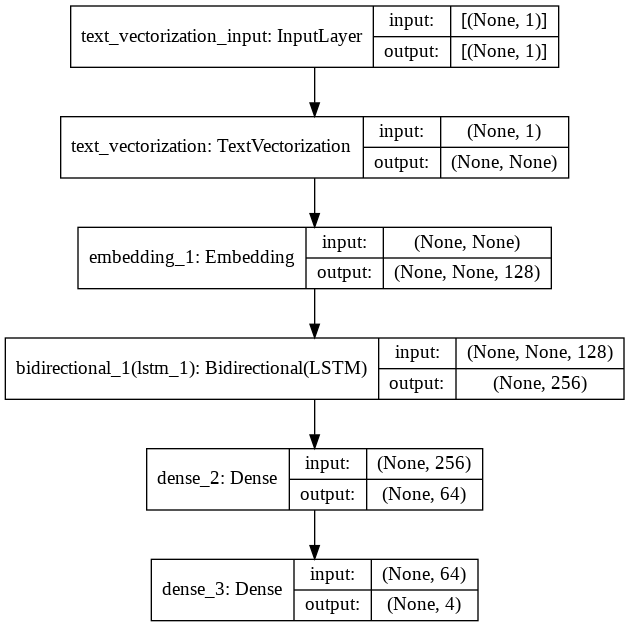

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 12 - Single Layer Bidirectional LSTM Output Dim 256**

## Create the model

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=256
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

## Compile Model 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

## Train the model

In [ ]:
start = time()

history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 57s 27ms/step - loss: 0.5958 - accuracy: 0.7778 - val_loss: 0.4417 - val_accuracy: 0.8467
Epoch 2/200
1782/1782 [==============================] - 47s 26ms/step - loss: 0.4191 - accuracy: 0.8501 - val_loss: 0.3999 - val_accuracy: 0.8602
Epoch 3/200
1782/1782 [==============================] - 46s 26ms/step - loss: 0.3974 - accuracy: 0.8568 - val_loss: 0.4114 - val_accuracy: 0.8532
Epoch 4/200
1782/1782 [==============================] - 46s 26ms/step - loss: 0.3864 - accuracy: 0.8599 - val_loss: 0.3847 - val_accuracy: 0.8612
Epoch 5/200
1782/1782 [==============================] - 47s 26ms/step - loss: 0.3778 - accuracy: 0.8615 - val_loss: 0.3755 - val_accuracy: 0.8635
Epoch 6/200
1782/1782 [==============================] - 48s 27ms/step - loss: 0.3706 - accuracy: 0.8642 - val_loss: 0.3962 - val_accuracy: 0.8533
Epoch 7/200
1782/1782 [==============================] - 45s 25ms/step - loss: 0.3626 - accuracy: 0.8673 - val_loss: 0

In [ ]:
model_time

872.182852268219

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 11ms/step - loss: 0.3803 - accuracy: 0.8616
Test Loss: 0.3803090751171112
Test Accuracy: 0.8615789413452148


## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.386,0.860,0.385,0.861
4,0.378,0.862,0.376,0.863
5,0.371,0.864,0.396,0.853
6,0.363,0.867,0.368,0.866
7,0.357,0.870,0.372,0.866
8,0.349,0.872,0.367,0.864
9,0.344,0.874,0.370,0.868
10,0.338,0.876,0.366,0.870
11,0.333,0.878,0.361,0.868
12,0.327,0.880,0.366,0.867


In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

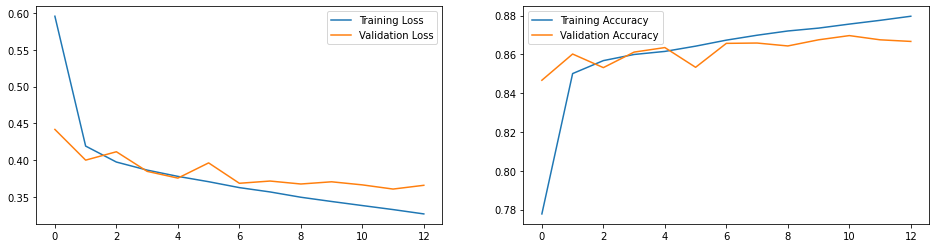

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,99.98%,0.01%,0.11%,99.84%,0.12%,0.34%,3.33%,89.74%,0.31%,99.95%,0.35%,0.41%,94.25%,99.16%
Sports,99.99%,0.01%,0.00%,99.86%,0.02%,0.05%,99.38%,96.25%,1.37%,0.03%,0.02%,0.83%,0.01%,0.51%,0.01%
Business,0.00%,0.01%,3.78%,0.01%,0.07%,7.42%,0.09%,0.06%,0.45%,88.09%,0.02%,0.82%,98.19%,0.72%,0.52%
Sci/Tech,0.00%,0.00%,96.20%,0.02%,0.08%,92.42%,0.19%,0.36%,8.44%,11.57%,0.01%,98.00%,1.38%,4.52%,0.30%


## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         256000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 1,339,716
Trainable params: 1,339,716
Non-trainable params: 0
_________________________________________________________________


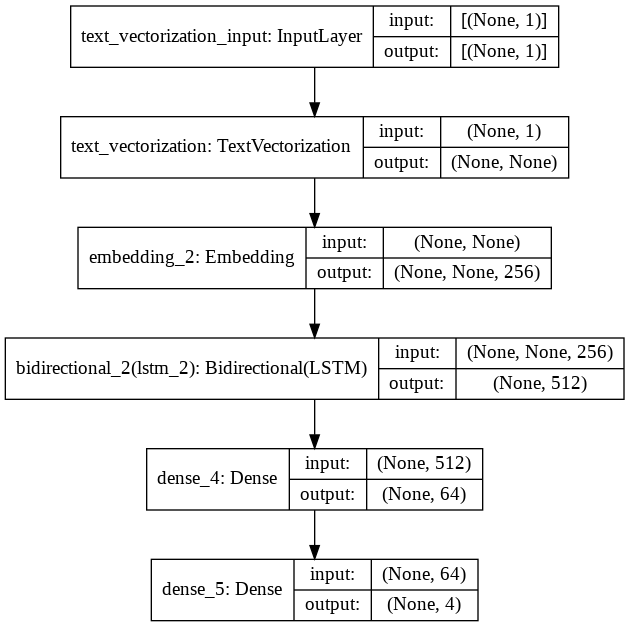

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 13**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.LSTM(64,  return_sequences=True)
                              ,tf.keras.layers.LSTM(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 44s 20ms/step - loss: 0.5520 - accuracy: 0.7989 - val_loss: 0.4336 - val_accuracy: 0.8438
Epoch 2/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4414 - accuracy: 0.8483 - val_loss: 0.4197 - val_accuracy: 0.8469
Epoch 3/200
1782/1782 [==============================] - 34s 19ms/step - loss: 0.4198 - accuracy: 0.8532 - val_loss: 0.3933 - val_accuracy: 0.8547
Epoch 4/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4036 - accuracy: 0.8587 - val_loss: 0.4088 - val_accuracy: 0.8521
Epoch 5/200
1782/1782 [==============================] - 34s 19ms/step - loss: 0.3887 - accuracy: 0.8640 - val_loss: 0.3747 - val_accuracy: 0.8672
Epoch 6/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.3770 - accuracy: 0.8676 - val_loss: 0.4135 - val_accuracy: 0.8547
Epoch 7/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.3629 - accuracy: 0.8714 - val_loss: 0

In [ ]:
model_time

264.6561210155487

In [ ]:
  test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 8ms/step - loss: 0.4001 - accuracy: 0.8509
Test Loss: 0.4001399576663971
Test Accuracy: 0.8509210348129272


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.420,0.853,0.393,0.855
3,0.404,0.859,0.409,0.852
4,0.389,0.864,0.375,0.867
5,0.377,0.868,0.413,0.855
6,0.363,0.871,0.405,0.859


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

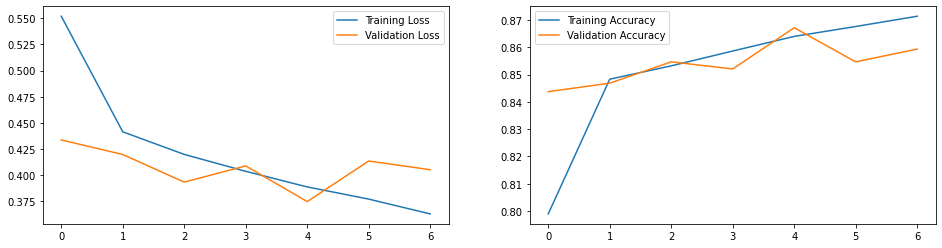

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,99.98%,0.01%,0.11%,99.84%,0.12%,0.34%,3.33%,89.74%,0.31%,99.95%,0.35%,0.41%,94.25%,99.16%
Sports,99.99%,0.01%,0.00%,99.86%,0.02%,0.05%,99.38%,96.25%,1.37%,0.03%,0.02%,0.83%,0.01%,0.51%,0.01%
Business,0.00%,0.01%,3.78%,0.01%,0.07%,7.42%,0.09%,0.06%,0.45%,88.09%,0.02%,0.82%,98.19%,0.72%,0.52%
Sci/Tech,0.00%,0.00%,96.20%,0.02%,0.08%,92.42%,0.19%,0.36%,8.44%,11.57%,0.01%,98.00%,1.38%,4.52%,0.30%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

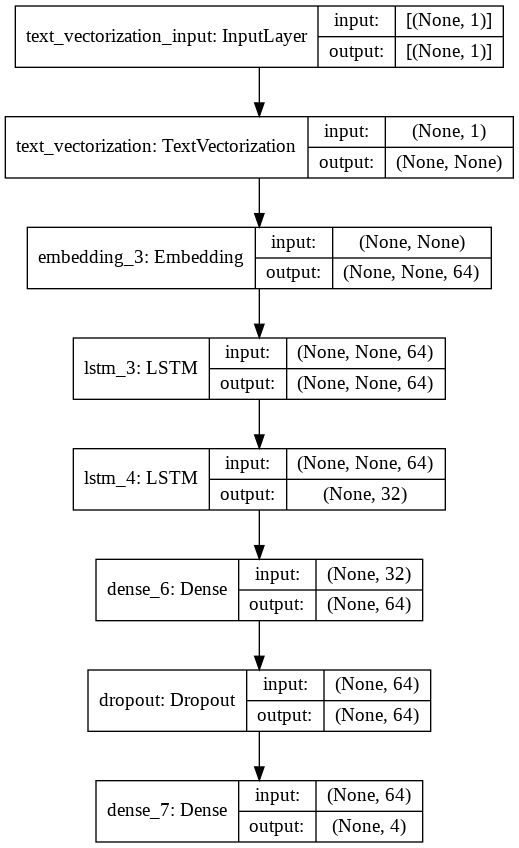

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 14**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.LSTM(128,  return_sequences=True)
                              ,tf.keras.layers.LSTM(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 51s 24ms/step - loss: 0.5388 - accuracy: 0.8057 - val_loss: 0.4201 - val_accuracy: 0.8615
Epoch 2/200
1782/1782 [==============================] - 37s 21ms/step - loss: 0.4402 - accuracy: 0.8482 - val_loss: 0.3886 - val_accuracy: 0.8568
Epoch 3/200
1782/1782 [==============================] - 39s 22ms/step - loss: 0.4150 - accuracy: 0.8558 - val_loss: 0.4175 - val_accuracy: 0.8547


In [ ]:
model_time

130.73900747299194

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 9ms/step - loss: 0.4175 - accuracy: 0.8504
Test Loss: 0.417490690946579
Test Accuracy: 0.8503947257995605


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.539,0.806,0.420,0.861
1,0.440,0.848,0.389,0.857
2,0.415,0.856,0.418,0.855


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

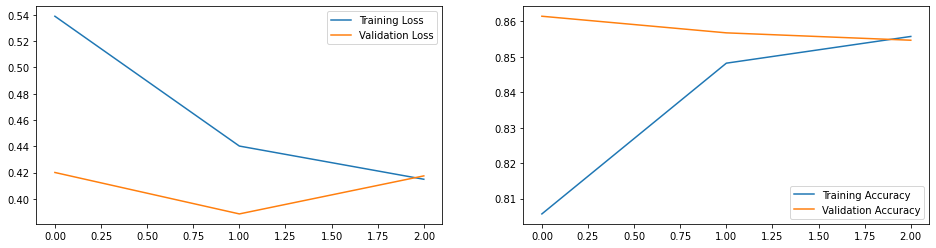

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,99.98%,0.01%,0.11%,99.84%,0.12%,0.34%,3.33%,89.74%,0.31%,99.95%,0.35%,0.41%,94.25%,99.16%
Sports,99.99%,0.01%,0.00%,99.86%,0.02%,0.05%,99.38%,96.25%,1.37%,0.03%,0.02%,0.83%,0.01%,0.51%,0.01%
Business,0.00%,0.01%,3.78%,0.01%,0.07%,7.42%,0.09%,0.06%,0.45%,88.09%,0.02%,0.82%,98.19%,0.72%,0.52%
Sci/Tech,0.00%,0.00%,96.20%,0.02%,0.08%,92.42%,0.19%,0.36%,8.44%,11.57%,0.01%,98.00%,1.38%,4.52%,0.30%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

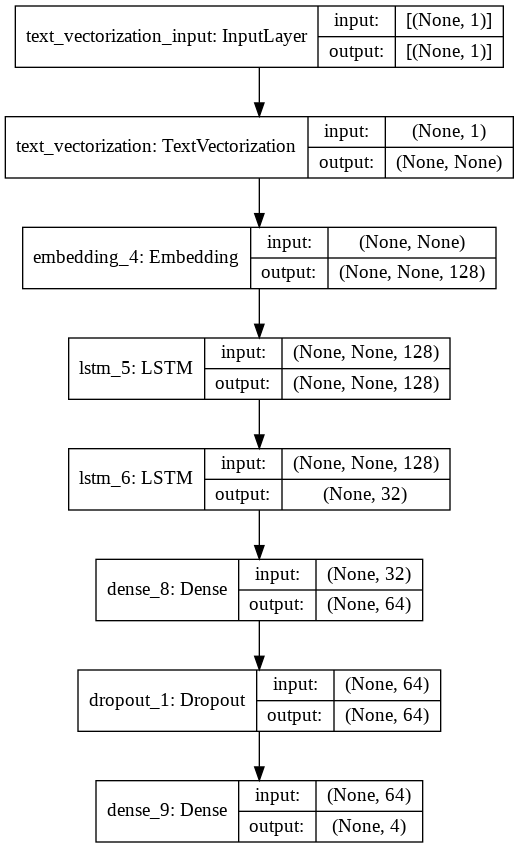

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 15**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.LSTM(256,  return_sequences=True)
                              ,tf.keras.layers.LSTM(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 55s 26ms/step - loss: 0.5308 - accuracy: 0.8120 - val_loss: 0.4342 - val_accuracy: 0.8547
Epoch 2/200
1782/1782 [==============================] - 44s 24ms/step - loss: 0.4383 - accuracy: 0.8494 - val_loss: 0.4283 - val_accuracy: 0.8526
Epoch 3/200
1782/1782 [==============================] - 44s 25ms/step - loss: 0.4106 - accuracy: 0.8571 - val_loss: 0.3760 - val_accuracy: 0.8641
Epoch 4/200
1782/1782 [==============================] - 43s 24ms/step - loss: 0.3864 - accuracy: 0.8659 - val_loss: 0.3854 - val_accuracy: 0.8667
Epoch 5/200
1782/1782 [==============================] - 45s 25ms/step - loss: 0.3650 - accuracy: 0.8722 - val_loss: 0.3847 - val_accuracy: 0.8609
Epoch 6/200
1782/1782 [==============================] - 45s 25ms/step - loss: 0.3403 - accuracy: 0.8796 - val_loss: 0.4006 - val_accuracy: 0.8599


In [ ]:
model_time

428.02630138397217

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 10ms/step - loss: 0.4023 - accuracy: 0.8587
Test Loss: 0.4023413360118866
Test Accuracy: 0.8586841821670532


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.438,0.849,0.428,0.853
2,0.411,0.857,0.376,0.864
3,0.386,0.866,0.385,0.867
4,0.365,0.872,0.385,0.861
5,0.340,0.880,0.401,0.860


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

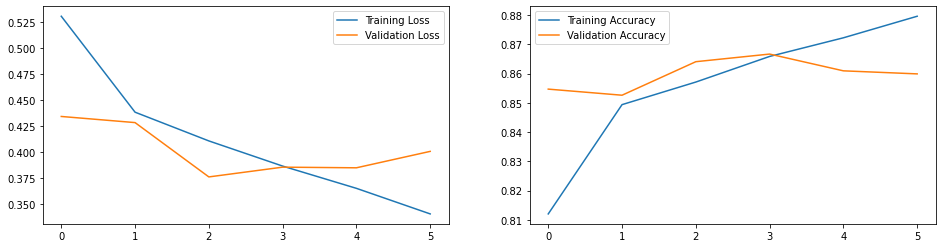

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,99.98%,0.01%,0.11%,99.84%,0.12%,0.34%,3.33%,89.74%,0.31%,99.95%,0.35%,0.41%,94.25%,99.16%
Sports,99.99%,0.01%,0.00%,99.86%,0.02%,0.05%,99.38%,96.25%,1.37%,0.03%,0.02%,0.83%,0.01%,0.51%,0.01%
Business,0.00%,0.01%,3.78%,0.01%,0.07%,7.42%,0.09%,0.06%,0.45%,88.09%,0.02%,0.82%,98.19%,0.72%,0.52%
Sci/Tech,0.00%,0.00%,96.20%,0.02%,0.08%,92.42%,0.19%,0.36%,8.44%,11.57%,0.01%,98.00%,1.38%,4.52%,0.30%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 256)         256000    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

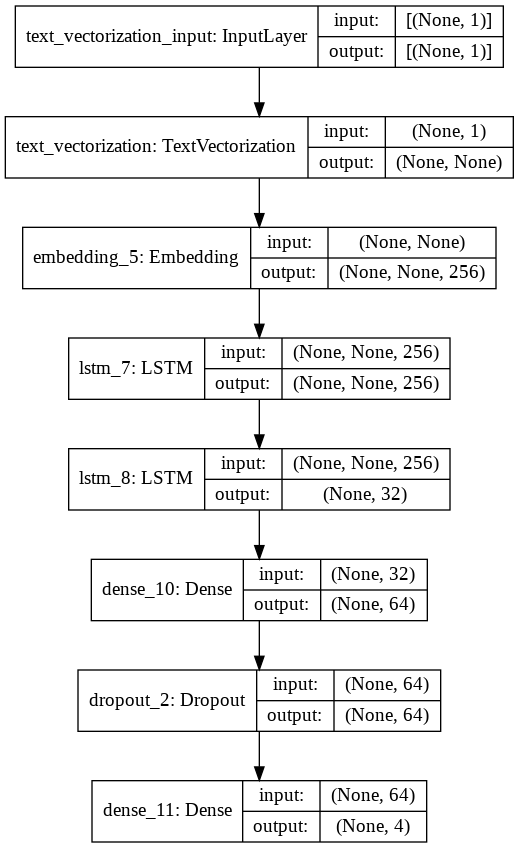

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 16**

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 79s 36ms/step - loss: 0.5294 - accuracy: 0.8089 - val_loss: 0.4413 - val_accuracy: 0.8453
Epoch 2/200
1782/1782 [==============================] - 58s 32ms/step - loss: 0.4283 - accuracy: 0.8514 - val_loss: 0.4224 - val_accuracy: 0.8401
Epoch 3/200
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4071 - accuracy: 0.8564 - val_loss: 0.3610 - val_accuracy: 0.8635
Epoch 4/200
1782/1782 [==============================] - 58s 32ms/step - loss: 0.3899 - accuracy: 0.8621 - val_loss: 0.3903 - val_accuracy: 0.8578
Epoch 5/200
1782/1782 [==============================] - 58s 33ms/step - loss: 0.3737 - accuracy: 0.8669 - val_loss: 0.3663 - val_accuracy: 0.8625


In [ ]:
model_time

354.2774279117584

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 14ms/step - loss: 0.3938 - accuracy: 0.8584
Test Loss: 0.39377227425575256
Test Accuracy: 0.8584210276603699


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.529,0.809,0.441,0.845
1,0.428,0.851,0.422,0.840
2,0.407,0.856,0.361,0.864
3,0.390,0.862,0.390,0.858
4,0.374,0.867,0.366,0.863


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

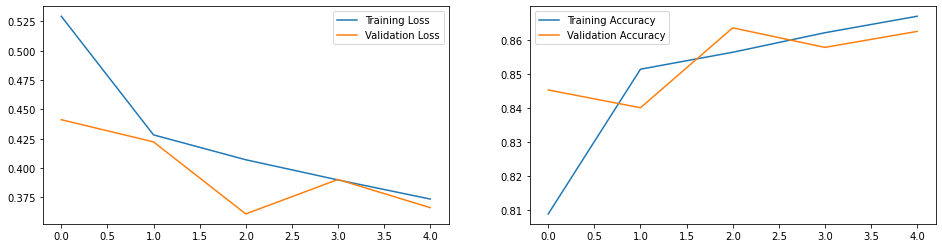

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,99.98%,0.01%,0.11%,99.84%,0.12%,0.34%,3.33%,89.74%,0.31%,99.95%,0.35%,0.41%,94.25%,99.16%
Sports,99.99%,0.01%,0.00%,99.86%,0.02%,0.05%,99.38%,96.25%,1.37%,0.03%,0.02%,0.83%,0.01%,0.51%,0.01%
Business,0.00%,0.01%,3.78%,0.01%,0.07%,7.42%,0.09%,0.06%,0.45%,88.09%,0.02%,0.82%,98.19%,0.72%,0.52%
Sci/Tech,0.00%,0.00%,96.20%,0.02%,0.08%,92.42%,0.19%,0.36%,8.44%,11.57%,0.01%,98.00%,1.38%,4.52%,0.30%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                

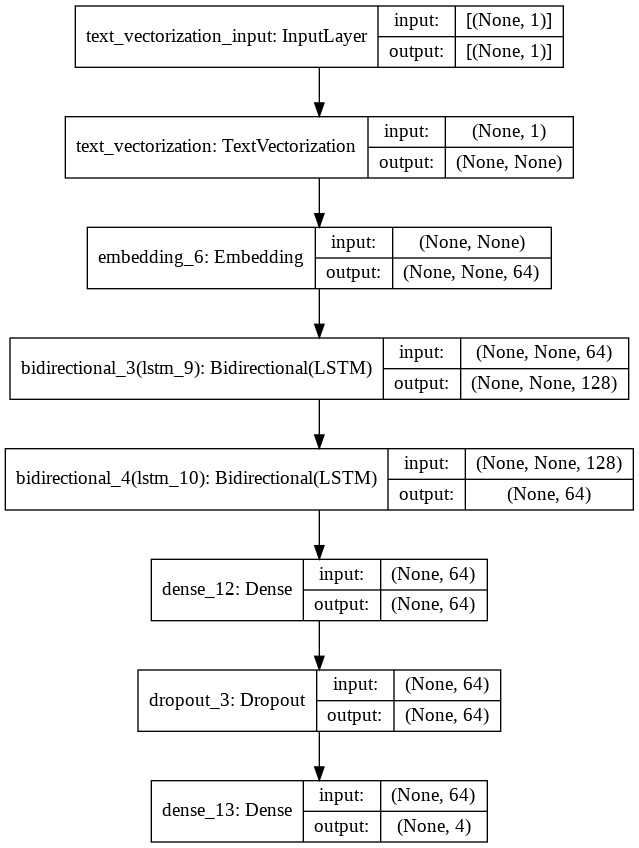

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 17**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 82s 37ms/step - loss: 0.5137 - accuracy: 0.8179 - val_loss: 0.4008 - val_accuracy: 0.8594
Epoch 2/200
1782/1782 [==============================] - 64s 36ms/step - loss: 0.4257 - accuracy: 0.8507 - val_loss: 0.3952 - val_accuracy: 0.8562
Epoch 3/200
1782/1782 [==============================] - 63s 35ms/step - loss: 0.4000 - accuracy: 0.8584 - val_loss: 0.3887 - val_accuracy: 0.8615
Epoch 4/200
1782/1782 [==============================] - 63s 35ms/step - loss: 0.3764 - accuracy: 0.8661 - val_loss: 0.3721 - val_accuracy: 0.8641
Epoch 5/200
1782/1782 [==============================] - 64s 36ms/step - loss: 0.3570 - accuracy: 0.8717 - val_loss: 0.3605 - val_accuracy: 0.8755
Epoch 6/200
1782/1782 [==============================] - 64s 36ms/step - loss: 0.3374 - accuracy: 0.8791 - val_loss: 0.3464 - val_accuracy: 0.8760
Epoch 7/200
1782/1782 [==============================] - 64s 36ms/step - loss: 0.3174 - accuracy: 0.8852 - val_loss: 0

In [ ]:
model_time

601.8515536785126

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 14ms/step - loss: 0.4123 - accuracy: 0.8609
Test Loss: 0.4123470187187195
Test Accuracy: 0.8609210252761841


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.376,0.866,0.372,0.864
4,0.357,0.872,0.360,0.876
5,0.337,0.879,0.346,0.876
6,0.317,0.885,0.381,0.861
7,0.295,0.893,0.352,0.873


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

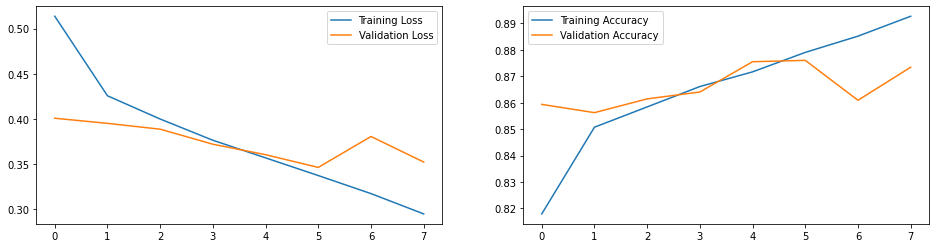

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,99.98%,0.01%,0.11%,99.84%,0.12%,0.34%,3.33%,89.74%,0.31%,99.95%,0.35%,0.41%,94.25%,99.16%
Sports,99.99%,0.01%,0.00%,99.86%,0.02%,0.05%,99.38%,96.25%,1.37%,0.03%,0.02%,0.83%,0.01%,0.51%,0.01%
Business,0.00%,0.01%,3.78%,0.01%,0.07%,7.42%,0.09%,0.06%,0.45%,88.09%,0.02%,0.82%,98.19%,0.72%,0.52%
Sci/Tech,0.00%,0.00%,96.20%,0.02%,0.08%,92.42%,0.19%,0.36%,8.44%,11.57%,0.01%,98.00%,1.38%,4.52%,0.30%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                73984     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

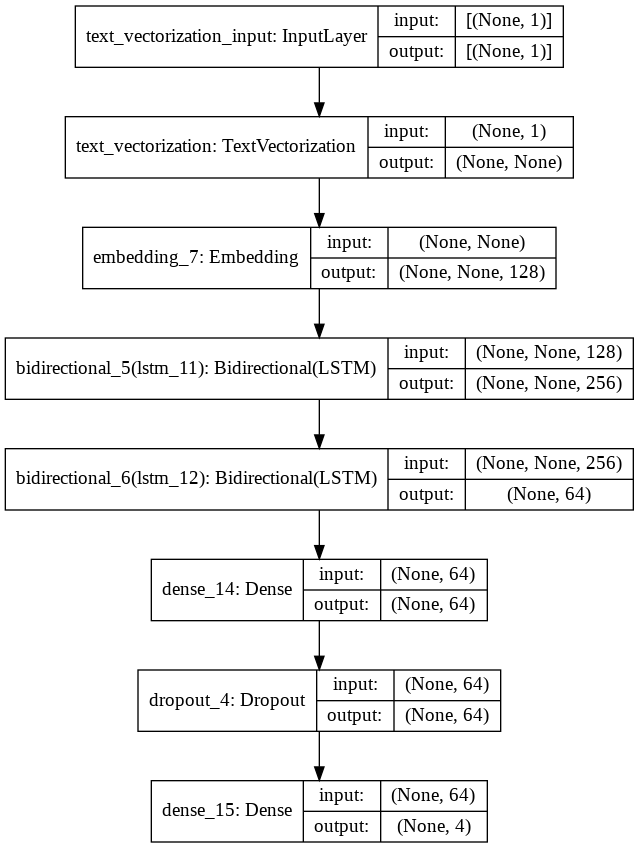

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 18**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 93s 42ms/step - loss: 0.5095 - accuracy: 0.8186 - val_loss: 0.3757 - val_accuracy: 0.8776
Epoch 2/200
1782/1782 [==============================] - 71s 40ms/step - loss: 0.4145 - accuracy: 0.8544 - val_loss: 0.3822 - val_accuracy: 0.8677
Epoch 3/200
1782/1782 [==============================] - 73s 41ms/step - loss: 0.3856 - accuracy: 0.8634 - val_loss: 0.3515 - val_accuracy: 0.8745


In [ ]:
model_time

251.9186782836914

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 18ms/step - loss: 0.4023 - accuracy: 0.8525
Test Loss: 0.40228092670440674
Test Accuracy: 0.8525000214576721


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.510,0.819,0.376,0.878
1,0.415,0.854,0.382,0.868
2,0.386,0.863,0.352,0.874


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

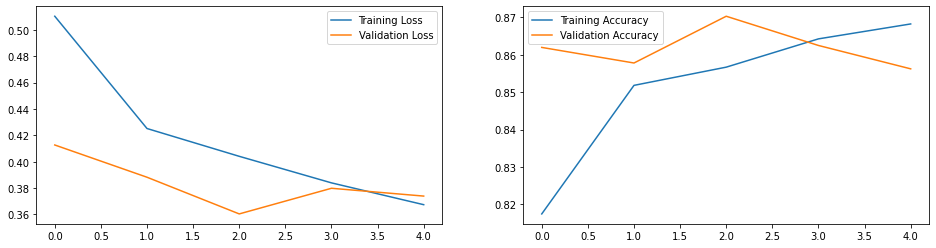

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,2.85%,99.93%,0.11%,1.08%,99.84%,0.75%,0.97%,31.65%,92.32%,2.54%,99.98%,0.23%,2.01%,90.32%,99.80%
Sports,96.52%,0.00%,0.02%,98.80%,0.02%,0.17%,98.70%,63.20%,2.12%,0.05%,0.00%,0.63%,0.01%,3.85%,0.00%
Business,0.17%,0.06%,4.62%,0.03%,0.11%,14.84%,0.06%,0.90%,3.82%,88.04%,0.02%,1.39%,96.77%,4.15%,0.18%
Sci/Tech,0.46%,0.00%,95.25%,0.09%,0.03%,84.24%,0.27%,4.25%,1.74%,9.38%,0.00%,97.75%,1.22%,1.67%,0.02%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

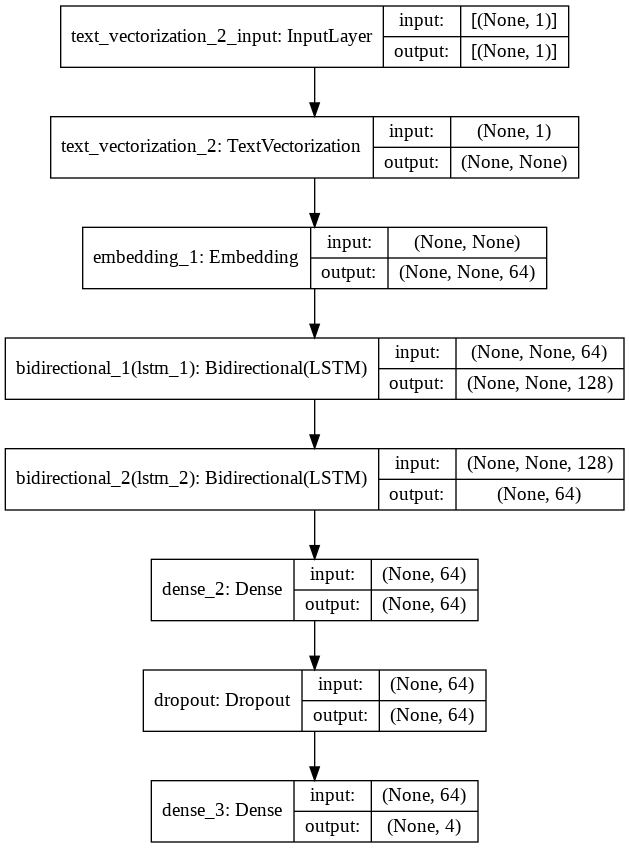

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# RELOAD

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=2000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

2000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U19')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['cabinet', 'spend', 'situation', 'rallied', 'person', 'journal',
       'enron', 'defeated', 'allowing', 'wins', 'tiny', 'seasons', 'kill',
       'indiana', 'edged', 'ebay', 'chinas', 'cards', 'brian', 'tight'],
      dtype='<U19')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 556,    1,    2, 1454,   59,  672,    1, 1235,   14,    2,    1,
           1,    1,    6,    1,    4,    3,    1,  382,   12,    2,  288,
         234,  344,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 946,   26,  537,    2,   39,   86,    6,  780,   77,    2,    1,
           1,    1,    1,    7,    1,    1,   26,   60,   31,    1,    8,
           2,  589,  161,   14,    1,   26, 1184,    2,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 705,  370,  112, 1096,    1,  639,  503, 1641, 1756,    1,    4,
           3,  449,  800,  684, 1234,   78,  131,  228,  362,    5,  711,
          11,  307,  250,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'David Wells, the pitcher who once fancied himself as the ultimate Yankee, agreeed in principle to a two-year contract with the Boston Red Sox.'
Round-trip:  david [UNK] the pitcher who once [UNK] himself as the [UNK] [UNK] [UNK] in [UNK] to a [UNK] contract with the boston red sox                              

Original:  b'2006 will mark the first time in 19 years the Kentucky Derby, Preakness Stakes and Belmont Stakes will not be shown on the same network as ABC will host the Belmont.'
Round-trip:  2006 will mark the first time in 19 years the [UNK] [UNK] [UNK] [UNK] and [UNK] [UNK] will not be [UNK] on the same network as [UNK] will host the [UNK]                       

Original:  b'5 October 2004 -- Afghan Transitional Administration Chairman Hamid Karzai traveled to a campaign rally outside Kabul today, four days ahead of Afghanistan #39;s presidential election.'
Round-trip:  5 october 2004 afghan [UNK] administration chairman hamid karzai [UNK] to a campaign rally o

# **EXPERIMENT 22**

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
num_classes = 4

model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 85s 36ms/step - loss: 0.4673 - accuracy: 0.8376 - val_loss: 0.3622 - val_accuracy: 0.8828
Epoch 2/200
1782/1782 [==============================] - 61s 34ms/step - loss: 0.3619 - accuracy: 0.8785 - val_loss: 0.3646 - val_accuracy: 0.8708
Epoch 3/200
1782/1782 [==============================] - 62s 35ms/step - loss: 0.3356 - accuracy: 0.8846 - val_loss: 0.3577 - val_accuracy: 0.8677


In [ ]:
model_time

239.50148224830627

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 18ms/step - loss: 0.3432 - accuracy: 0.8776
Test Loss: 0.3431646525859833
Test Accuracy: 0.8776316046714783


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.467,0.838,0.362,0.883
1,0.362,0.878,0.365,0.871
2,0.336,0.885,0.358,0.868


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

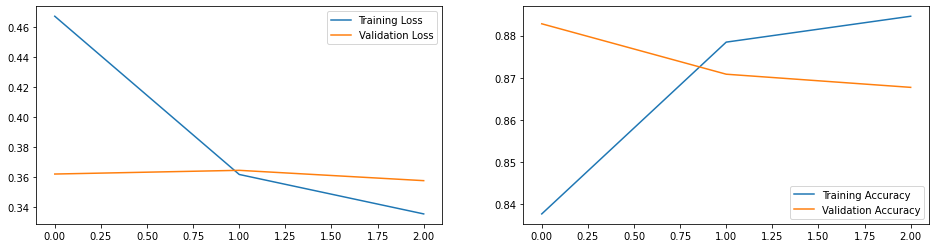

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.06%,99.84%,0.03%,0.57%,99.81%,0.12%,1.34%,6.88%,89.56%,0.21%,99.94%,4.10%,0.56%,66.29%,99.86%
Sports,99.92%,0.00%,0.00%,99.32%,0.00%,0.00%,97.51%,91.97%,0.18%,0.00%,0.00%,0.25%,0.00%,1.42%,0.00%
Business,0.01%,0.11%,6.21%,0.06%,0.11%,4.35%,0.60%,0.24%,1.22%,98.43%,0.05%,2.09%,98.45%,3.65%,0.09%
Sci/Tech,0.01%,0.05%,93.76%,0.05%,0.07%,95.53%,0.55%,0.91%,9.04%,1.37%,0.01%,93.56%,0.99%,28.64%,0.05%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          128000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

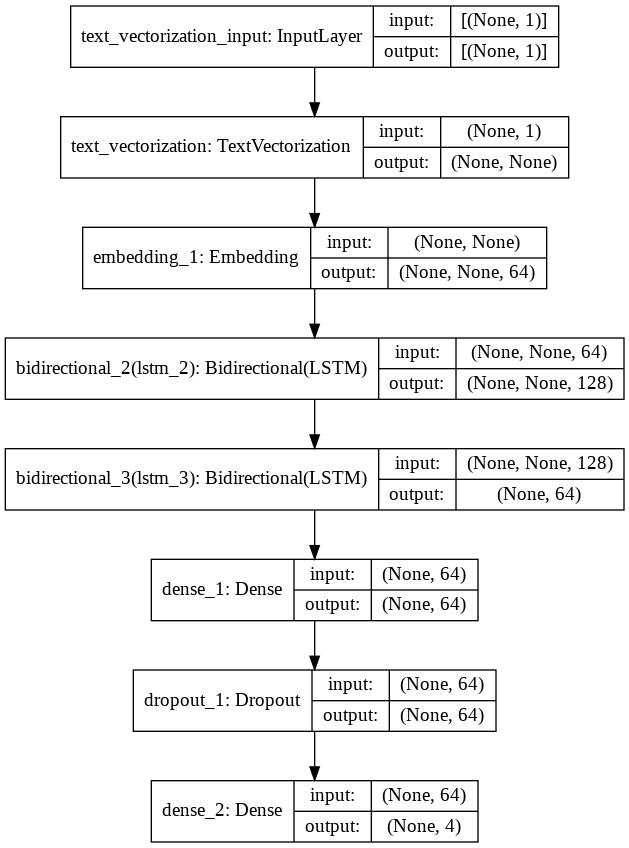

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 23**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 90s 41ms/step - loss: 0.4470 - accuracy: 0.8458 - val_loss: 0.3986 - val_accuracy: 0.8557
Epoch 2/200
1782/1782 [==============================] - 69s 39ms/step - loss: 0.3549 - accuracy: 0.8781 - val_loss: 0.3603 - val_accuracy: 0.8807
Epoch 3/200
1782/1782 [==============================] - 71s 40ms/step - loss: 0.3249 - accuracy: 0.8874 - val_loss: 0.3214 - val_accuracy: 0.8870
Epoch 4/200
1782/1782 [==============================] - 69s 39ms/step - loss: 0.2983 - accuracy: 0.8956 - val_loss: 0.3303 - val_accuracy: 0.8911
Epoch 5/200
1782/1782 [==============================] - 68s 38ms/step - loss: 0.2730 - accuracy: 0.9031 - val_loss: 0.3557 - val_accuracy: 0.8781
Epoch 6/200
1782/1782 [==============================] - 69s 38ms/step - loss: 0.2500 - accuracy: 0.9110 - val_loss: 0.3401 - val_accuracy: 0.8833


In [ ]:
model_time

475.7926998138428

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 15ms/step - loss: 0.3532 - accuracy: 0.8843
Test Loss: 0.3531697392463684
Test Accuracy: 0.8843421339988708


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.355,0.878,0.360,0.881
2,0.325,0.887,0.321,0.887
3,0.298,0.896,0.330,0.891
4,0.273,0.903,0.356,0.878
5,0.250,0.911,0.340,0.883


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

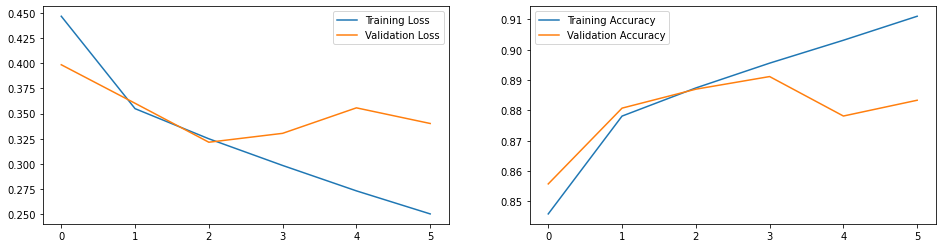

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.01%,100.00%,0.01%,0.15%,99.99%,0.15%,1.55%,0.07%,98.31%,0.05%,100.00%,0.85%,0.14%,99.03%,99.99%
Sports,99.99%,0.00%,0.00%,99.84%,0.00%,0.00%,98.39%,99.92%,0.04%,0.00%,0.00%,0.49%,0.00%,0.03%,0.00%
Business,0.00%,0.00%,2.66%,0.01%,0.01%,11.48%,0.03%,0.00%,0.61%,99.84%,0.00%,3.92%,99.82%,0.12%,0.00%
Sci/Tech,0.00%,0.00%,97.33%,0.00%,0.00%,88.36%,0.03%,0.01%,1.04%,0.11%,0.00%,94.74%,0.04%,0.82%,0.00%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                73984     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

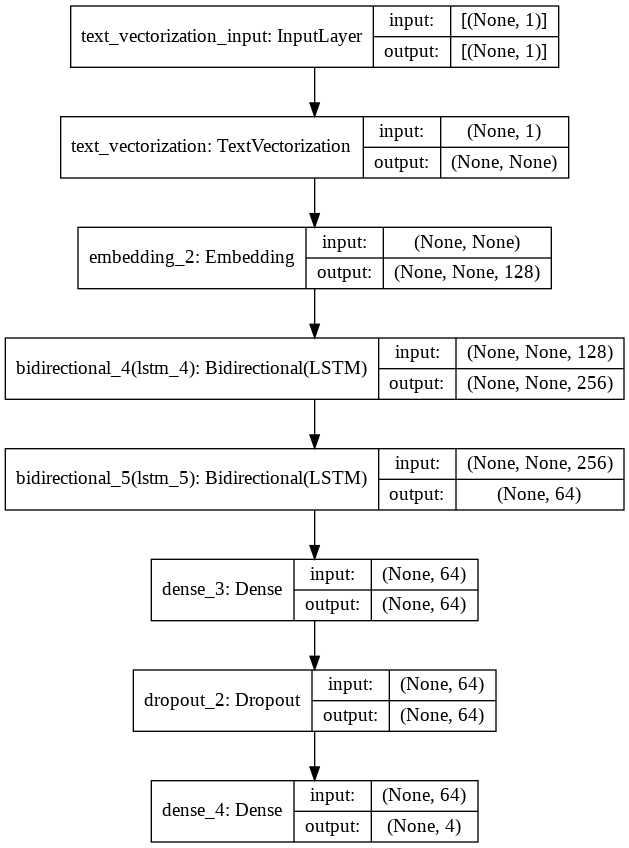

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 24**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 98s 45ms/step - loss: 0.4461 - accuracy: 0.8455 - val_loss: 0.3838 - val_accuracy: 0.8667
Epoch 2/200
1782/1782 [==============================] - 80s 45ms/step - loss: 0.3496 - accuracy: 0.8802 - val_loss: 0.3386 - val_accuracy: 0.8708
Epoch 3/200
1782/1782 [==============================] - 82s 46ms/step - loss: 0.3154 - accuracy: 0.8902 - val_loss: 0.3276 - val_accuracy: 0.8906
Epoch 4/200
1782/1782 [==============================] - 81s 45ms/step - loss: 0.2855 - accuracy: 0.8997 - val_loss: 0.3475 - val_accuracy: 0.8776
Epoch 5/200
1782/1782 [==============================] - 80s 45ms/step - loss: 0.2573 - accuracy: 0.9090 - val_loss: 0.3200 - val_accuracy: 0.8865


In [ ]:
model_time

482.7833936214447

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 18ms/step - loss: 0.3355 - accuracy: 0.8838
Test Loss: 0.3354610204696655
Test Accuracy: 0.8838157653808594


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.446,0.846,0.384,0.867
1,0.350,0.880,0.339,0.871
2,0.315,0.890,0.328,0.891
3,0.286,0.900,0.348,0.878
4,0.257,0.909,0.320,0.886


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

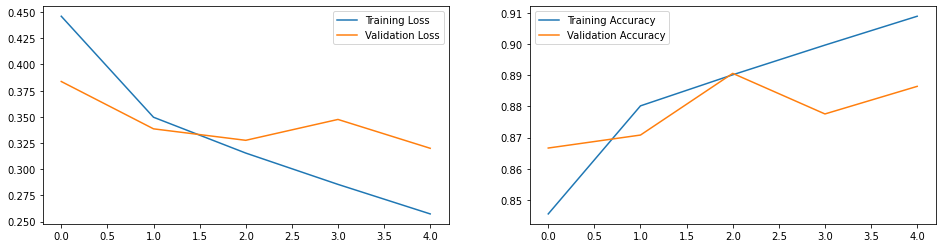

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.03%,99.99%,0.06%,4.35%,99.96%,0.06%,17.47%,0.04%,89.78%,0.04%,100.00%,1.00%,0.20%,82.33%,99.93%
Sports,99.96%,0.00%,0.00%,95.60%,0.00%,0.00%,80.87%,99.96%,0.04%,0.00%,0.00%,0.49%,0.00%,0.29%,0.00%
Business,0.00%,0.00%,4.69%,0.02%,0.04%,9.43%,0.86%,0.00%,2.93%,99.83%,0.00%,9.24%,99.69%,5.32%,0.06%
Sci/Tech,0.00%,0.00%,95.25%,0.03%,0.00%,90.50%,0.80%,0.00%,7.25%,0.13%,0.00%,89.26%,0.11%,12.07%,0.01%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 256)         512000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 512)         1050624   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                139520    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

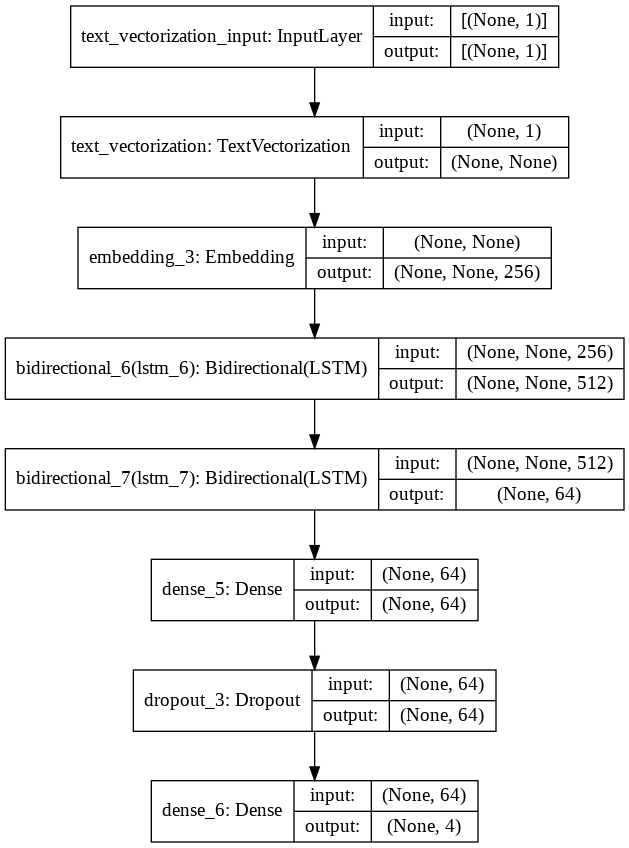

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# RELOAD

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=3000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

3000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U21')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['barely', 'bar', 'xbox', 'teammate', 'silver', 'secondquarter',
       'referendum', 'quality', 'population', 'plenty', 'palm',
       'operators', 'memphis', 'materials', 'language', 'landing',
       'homeland', 'friendly', 'firsthalf', 'fed'], dtype='<U21')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 556,    1,    2, 1454,   59,  672,    1, 1235,   14,    2,    1,
           1,    1,    6,    1,    4,    3, 2674,  382,   12,    2,  288,
         234,  344,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 946,   26,  537,    2,   39,   86,    6,  780,   77,    2,    1,
           1,    1,    1,    7,    1,    1,   26,   60,   31, 2969,    8,
           2,  589,  161,   14,    1,   26, 1184,    2,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 705,  370,  112, 1096,    1,  639,  503, 1641, 1756,    1,    4,
           3,  449,  800,  684, 1234,   78,  131,  228,  362,    5,  711,
          11,  307,  250,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'David Wells, the pitcher who once fancied himself as the ultimate Yankee, agreeed in principle to a two-year contract with the Boston Red Sox.'
Round-trip:  david [UNK] the pitcher who once [UNK] himself as the [UNK] [UNK] [UNK] in [UNK] to a twoyear contract with the boston red sox                              

Original:  b'2006 will mark the first time in 19 years the Kentucky Derby, Preakness Stakes and Belmont Stakes will not be shown on the same network as ABC will host the Belmont.'
Round-trip:  2006 will mark the first time in 19 years the [UNK] [UNK] [UNK] [UNK] and [UNK] [UNK] will not be shown on the same network as [UNK] will host the [UNK]                       

Original:  b'5 October 2004 -- Afghan Transitional Administration Chairman Hamid Karzai traveled to a campaign rally outside Kabul today, four days ahead of Afghanistan #39;s presidential election.'
Round-trip:  5 october 2004 afghan [UNK] administration chairman hamid karzai [UNK] to a campaign rally

# **EXPERIMENT 25**

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
num_classes = 4

model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 86s 39ms/step - loss: 0.4357 - accuracy: 0.8505 - val_loss: 0.3192 - val_accuracy: 0.8859
Epoch 2/200
1782/1782 [==============================] - 66s 37ms/step - loss: 0.3302 - accuracy: 0.8897 - val_loss: 0.3201 - val_accuracy: 0.8854
Epoch 3/200
1782/1782 [==============================] - 67s 37ms/step - loss: 0.3019 - accuracy: 0.8975 - val_loss: 0.3266 - val_accuracy: 0.8901
Epoch 4/200
1782/1782 [==============================] - 65s 36ms/step - loss: 0.2763 - accuracy: 0.9048 - val_loss: 0.2866 - val_accuracy: 0.8953
Epoch 5/200
1782/1782 [==============================] - 62s 35ms/step - loss: 0.2534 - accuracy: 0.9119 - val_loss: 0.3069 - val_accuracy: 0.8849
Epoch 6/200
1782/1782 [==============================] - 63s 35ms/step - loss: 0.2325 - accuracy: 0.9182 - val_loss: 0.3294 - val_accuracy: 0.8891


In [ ]:
model_time

441.5390522480011

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 6s 14ms/step - loss: 0.3424 - accuracy: 0.8926
Test Loss: 0.34240272641181946
Test Accuracy: 0.8926315903663635


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.330,0.890,0.320,0.885
2,0.302,0.897,0.327,0.890
3,0.276,0.905,0.287,0.895
4,0.253,0.912,0.307,0.885
5,0.232,0.918,0.329,0.889


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

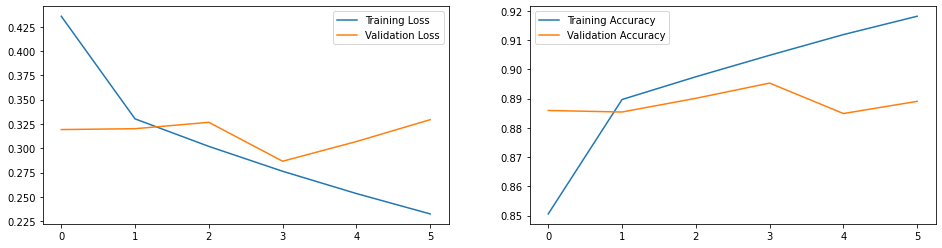

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.04%,100.00%,0.01%,0.22%,99.99%,0.10%,0.29%,0.22%,99.92%,0.07%,100.00%,0.01%,0.20%,78.95%,100.00%
Sports,99.96%,0.00%,0.00%,99.77%,0.00%,0.00%,99.58%,99.78%,0.00%,0.00%,0.00%,0.00%,0.00%,0.90%,0.00%
Business,0.00%,0.00%,0.25%,0.00%,0.01%,1.66%,0.04%,0.00%,0.05%,99.53%,0.00%,0.03%,99.76%,1.43%,0.00%
Sci/Tech,0.00%,0.00%,99.75%,0.00%,0.00%,98.24%,0.09%,0.00%,0.02%,0.40%,0.00%,99.96%,0.03%,18.73%,0.00%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

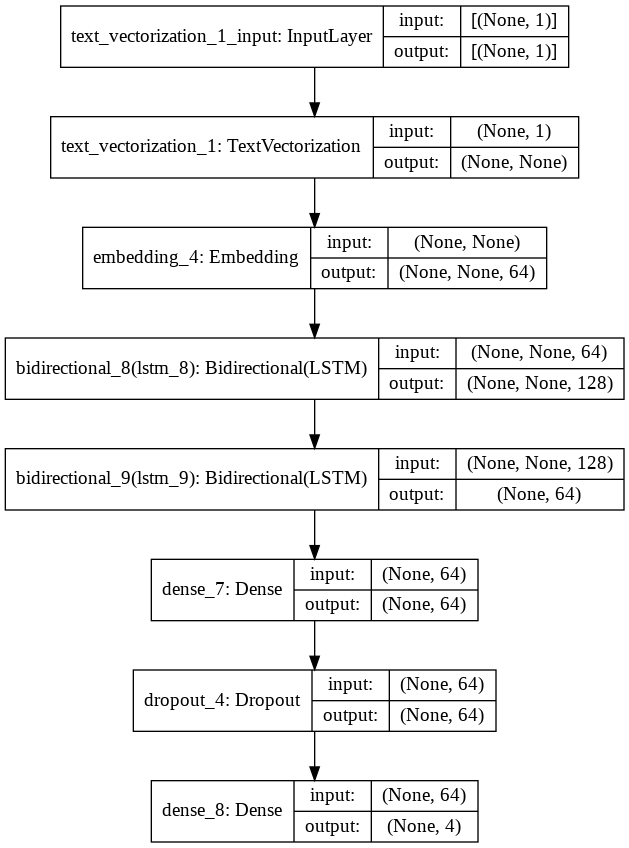

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 26**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 90s 41ms/step - loss: 0.4253 - accuracy: 0.8549 - val_loss: 0.3372 - val_accuracy: 0.8896
Epoch 2/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.3270 - accuracy: 0.8899 - val_loss: 0.3142 - val_accuracy: 0.8911
Epoch 3/200
1782/1782 [==============================] - 72s 40ms/step - loss: 0.2910 - accuracy: 0.9002 - val_loss: 0.3052 - val_accuracy: 0.8953
Epoch 4/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.2624 - accuracy: 0.9080 - val_loss: 0.3371 - val_accuracy: 0.8813
Epoch 5/200
1782/1782 [==============================] - 71s 40ms/step - loss: 0.2327 - accuracy: 0.9186 - val_loss: 0.3257 - val_accuracy: 0.8891


In [ ]:
model_time

406.6536922454834

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 15ms/step - loss: 0.3432 - accuracy: 0.8876
Test Loss: 0.3431739807128906
Test Accuracy: 0.8876315951347351


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.425,0.855,0.337,0.890
1,0.327,0.890,0.314,0.891
2,0.291,0.900,0.305,0.895
3,0.262,0.908,0.337,0.881
4,0.233,0.919,0.326,0.889


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

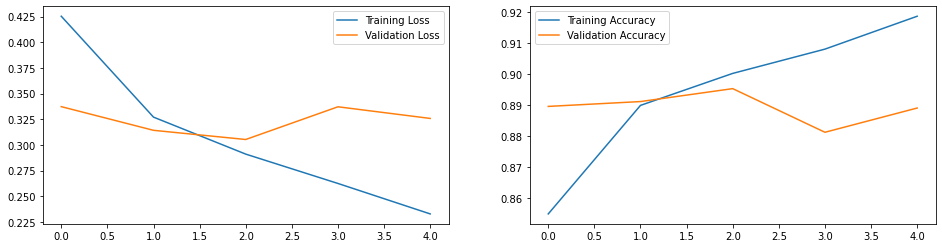

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.01%,99.99%,0.01%,0.53%,99.99%,0.08%,2.93%,0.12%,99.89%,0.07%,100.00%,0.11%,0.31%,97.32%,99.99%
Sports,99.99%,0.00%,0.00%,99.46%,0.00%,0.01%,96.72%,99.88%,0.00%,0.00%,0.00%,0.00%,0.00%,0.07%,0.00%
Business,0.00%,0.01%,0.17%,0.01%,0.00%,5.63%,0.14%,0.00%,0.05%,99.89%,0.00%,0.04%,99.64%,0.09%,0.00%
Sci/Tech,0.00%,0.00%,99.83%,0.01%,0.00%,94.28%,0.22%,0.00%,0.05%,0.04%,0.00%,99.85%,0.05%,2.52%,0.00%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 128)         384000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 256)         263168    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

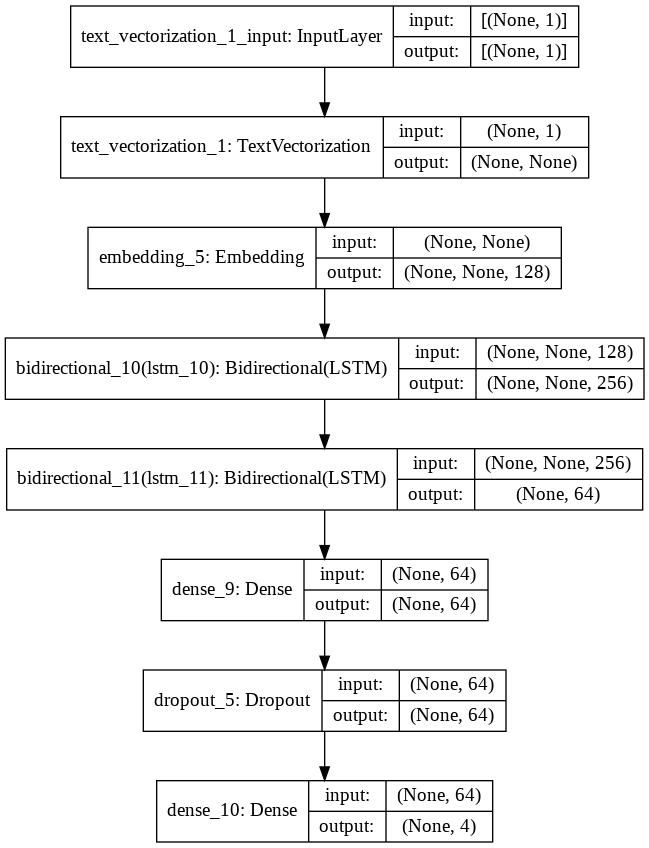

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 27**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 102s 49ms/step - loss: 0.4257 - accuracy: 0.8551 - val_loss: 0.3245 - val_accuracy: 0.8885
Epoch 2/200
1782/1782 [==============================] - 83s 46ms/step - loss: 0.3206 - accuracy: 0.8917 - val_loss: 0.3195 - val_accuracy: 0.8839
Epoch 3/200
1782/1782 [==============================] - 82s 46ms/step - loss: 0.2842 - accuracy: 0.9022 - val_loss: 0.3185 - val_accuracy: 0.8875


In [ ]:
model_time

326.4074833393097

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 16s 18ms/step - loss: 0.3335 - accuracy: 0.8871
Test Loss: 0.33346474170684814
Test Accuracy: 0.8871052861213684


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.426,0.855,0.325,0.889
1,0.321,0.892,0.320,0.884
2,0.284,0.902,0.319,0.887


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

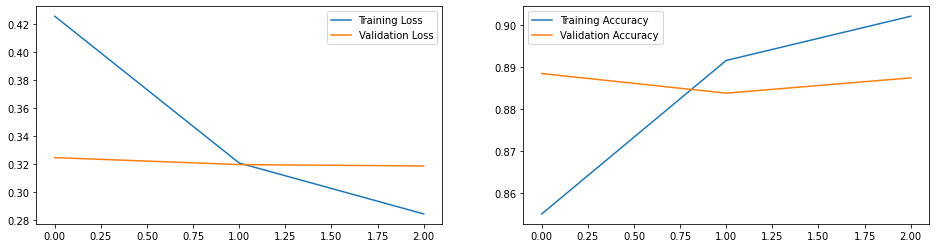

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.07%,99.93%,0.03%,0.98%,99.81%,0.03%,0.54%,0.27%,98.18%,0.10%,99.98%,0.04%,0.56%,49.48%,99.93%
Sports,99.93%,0.00%,0.00%,99.01%,0.00%,0.00%,99.42%,99.72%,0.06%,0.01%,0.00%,0.00%,0.01%,4.73%,0.00%
Business,0.00%,0.05%,0.38%,0.01%,0.14%,1.46%,0.02%,0.00%,0.93%,99.35%,0.02%,0.22%,98.64%,11.79%,0.06%
Sci/Tech,0.00%,0.01%,99.59%,0.00%,0.04%,98.51%,0.02%,0.00%,0.84%,0.55%,0.00%,99.74%,0.79%,34.00%,0.01%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 256)         768000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 512)         1050624   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                139520    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                

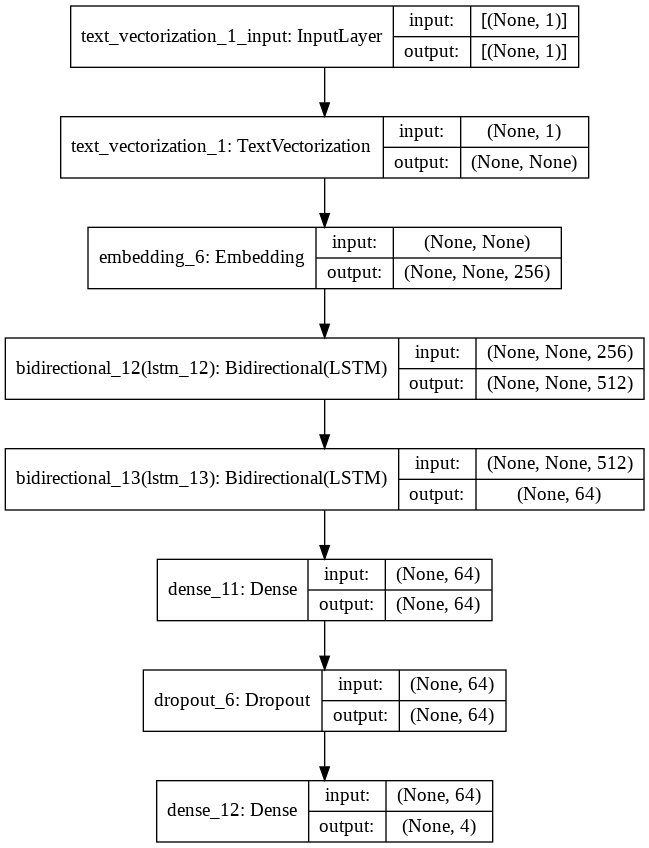

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# RELOAD

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
VOCAB_SIZE=10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

10000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U56')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['secondranked', 'scream', 'scoreboard', 'schmidt', 'schemes',
       'schalke', 'samesex', 'salvaged', 'runaway', 'rodrigo', 'robbed',
       'rite', 'ringers', 'richter', 'richards', 'relax', 'referring',
       'reactions', 'ravaged', 'rachel'], dtype='<U56')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 556, 5157,    2, 1454,   59,  672,    1, 1235,   14,    2, 6081,
        3440,    1,    6, 6187,    4,    3, 2674,  382,   12,    2,  288,
         234,  344,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 946,   26,  537,    2,   39,   86,    6,  780,   77,    2, 5570,
        5911,    1, 4150,    7,    1, 4150,   26,   60,   31, 2969,    8,
           2,  589,  161,   14, 4920,   26, 1184,    2,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 705,  370,  112, 1096,    1,  639,  503, 1641, 1756, 7796,    4,
           3,  449,  800,  684, 1234,   78,  131,  228,  362,    5,  711,
          11,  307,  250,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'David Wells, the pitcher who once fancied himself as the ultimate Yankee, agreeed in principle to a two-year contract with the Boston Red Sox.'
Round-trip:  david wells the pitcher who once [UNK] himself as the ultimate yankee [UNK] in principle to a twoyear contract with the boston red sox                              

Original:  b'2006 will mark the first time in 19 years the Kentucky Derby, Preakness Stakes and Belmont Stakes will not be shown on the same network as ABC will host the Belmont.'
Round-trip:  2006 will mark the first time in 19 years the kentucky derby [UNK] stakes and [UNK] stakes will not be shown on the same network as abc will host the [UNK]                       

Original:  b'5 October 2004 -- Afghan Transitional Administration Chairman Hamid Karzai traveled to a campaign rally outside Kabul today, four days ahead of Afghanistan #39;s presidential election.'
Round-trip:  5 october 2004 afghan [UNK] administration chairman hamid karzai traveled to a 

# **EXPERIMENT 28**

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [ ]:
num_classes = 4

model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 88s 40ms/step - loss: 0.4053 - accuracy: 0.8590 - val_loss: 0.2794 - val_accuracy: 0.9062
Epoch 2/200
1782/1782 [==============================] - 68s 38ms/step - loss: 0.2642 - accuracy: 0.9150 - val_loss: 0.2906 - val_accuracy: 0.8964
Epoch 3/200
1782/1782 [==============================] - 68s 38ms/step - loss: 0.2197 - accuracy: 0.9277 - val_loss: 0.3100 - val_accuracy: 0.9021


In [ ]:
model_time

238.12761306762695

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 14ms/step - loss: 0.3040 - accuracy: 0.9022
Test Loss: 0.3040353059768677
Test Accuracy: 0.902236819267273


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.405,0.859,0.279,0.906
1,0.264,0.915,0.291,0.896
2,0.220,0.928,0.310,0.902


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

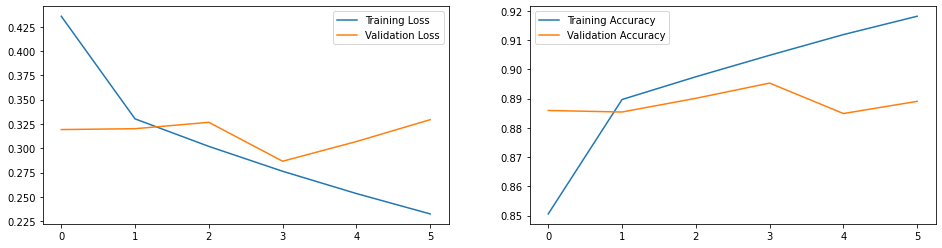

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.04%,100.00%,0.01%,0.22%,99.99%,0.10%,0.29%,0.22%,99.92%,0.07%,100.00%,0.01%,0.20%,78.95%,100.00%
Sports,99.96%,0.00%,0.00%,99.77%,0.00%,0.00%,99.58%,99.78%,0.00%,0.00%,0.00%,0.00%,0.00%,0.90%,0.00%
Business,0.00%,0.00%,0.25%,0.00%,0.01%,1.66%,0.04%,0.00%,0.05%,99.53%,0.00%,0.03%,99.76%,1.43%,0.00%
Sci/Tech,0.00%,0.00%,99.75%,0.00%,0.00%,98.24%,0.09%,0.00%,0.02%,0.40%,0.00%,99.96%,0.03%,18.73%,0.00%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

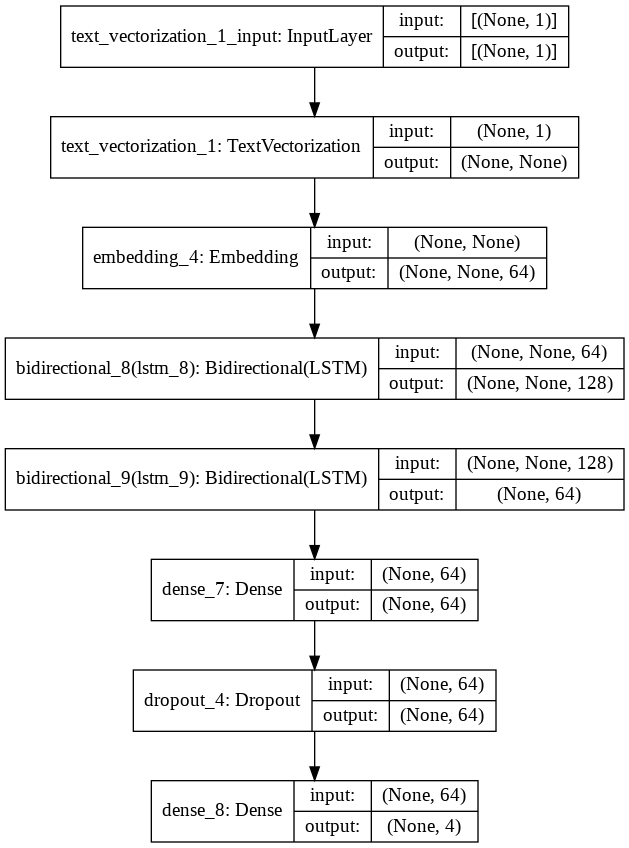

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 29**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 106s 50ms/step - loss: 0.3888 - accuracy: 0.8689 - val_loss: 0.3066 - val_accuracy: 0.9005
Epoch 2/200
1782/1782 [==============================] - 84s 47ms/step - loss: 0.2585 - accuracy: 0.9150 - val_loss: 0.2800 - val_accuracy: 0.9042
Epoch 3/200
1782/1782 [==============================] - 85s 47ms/step - loss: 0.2115 - accuracy: 0.9290 - val_loss: 0.3025 - val_accuracy: 0.9120
Epoch 4/200
1782/1782 [==============================] - 86s 48ms/step - loss: 0.1636 - accuracy: 0.9444 - val_loss: 0.3280 - val_accuracy: 0.9151
Epoch 5/200
1782/1782 [==============================] - 85s 47ms/step - loss: 0.1240 - accuracy: 0.9574 - val_loss: 0.4102 - val_accuracy: 0.8958
Epoch 6/200
1782/1782 [==============================] - 86s 48ms/step - loss: 0.0936 - accuracy: 0.9673 - val_loss: 0.4940 - val_accuracy: 0.8859


In [ ]:
model_time

704.1820838451385

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 15ms/step - loss: 0.4932 - accuracy: 0.8845
Test Loss: 0.4932352900505066
Test Accuracy: 0.8844736814498901


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.258,0.915,0.280,0.904
2,0.212,0.929,0.302,0.912
3,0.164,0.944,0.328,0.915
4,0.124,0.957,0.410,0.896
5,0.094,0.967,0.494,0.886


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

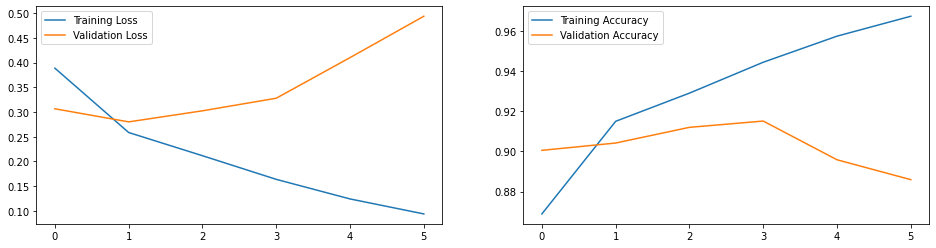

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.01%,100.00%,0.00%,0.01%,96.13%,0.00%,0.00%,0.00%,100.00%,0.00%,100.00%,0.00%,0.01%,100.00%,100.00%
Sports,99.99%,0.00%,0.00%,99.99%,0.00%,0.00%,100.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Business,0.00%,0.00%,0.13%,0.00%,0.02%,13.38%,0.00%,0.00%,0.00%,99.98%,0.00%,0.05%,99.98%,0.00%,0.00%
Sci/Tech,0.00%,0.00%,99.87%,0.00%,3.84%,86.62%,0.00%,0.00%,0.00%,0.02%,0.00%,99.95%,0.01%,0.00%,0.00%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 256)         263168    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                

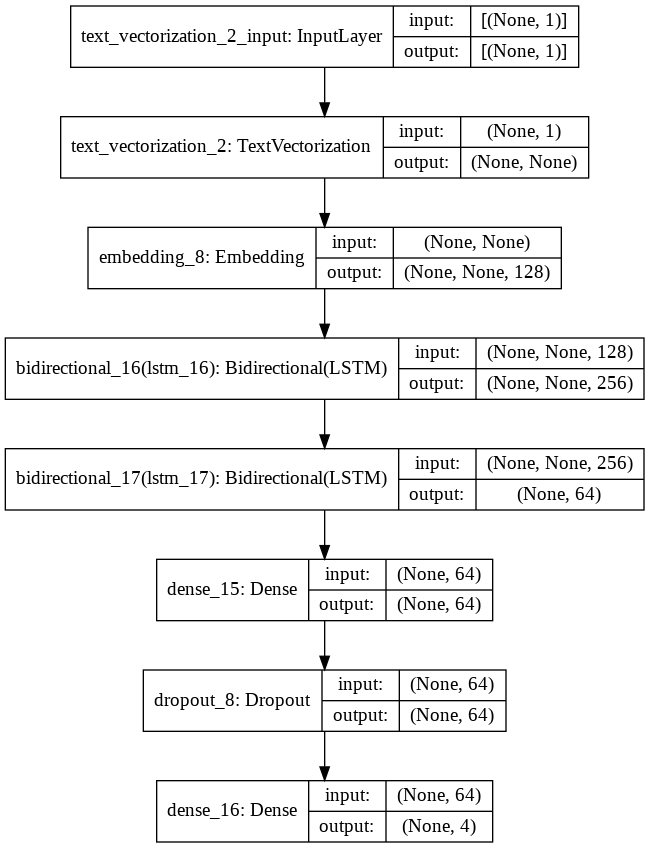

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

# **EXPERIMENT 30**

## Stack two or more LSTM layers



In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
start = time()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

model_time = time() - start

Epoch 1/200
1782/1782 [==============================] - 125s 58ms/step - loss: 0.4035 - accuracy: 0.8638 - val_loss: 0.2942 - val_accuracy: 0.8979
Epoch 2/200
1782/1782 [==============================] - 94s 53ms/step - loss: 0.2703 - accuracy: 0.9122 - val_loss: 0.2931 - val_accuracy: 0.8974
Epoch 3/200
1782/1782 [==============================] - 98s 55ms/step - loss: 0.2295 - accuracy: 0.9245 - val_loss: 0.3323 - val_accuracy: 0.8896


In [ ]:
model_time

365.55184984207153

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 20ms/step - loss: 0.3077 - accuracy: 0.8953
Test Loss: 0.3076889216899872
Test Accuracy: 0.895263135433197


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.403,0.864,0.294,0.898
1,0.270,0.912,0.293,0.897
2,0.230,0.924,0.332,0.890


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

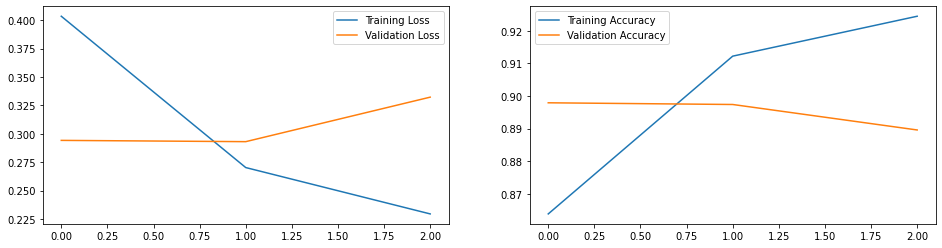

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
preds = model2.predict(test_dataset)

In [ ]:
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.09%,99.98%,0.21%,0.16%,99.67%,0.12%,0.02%,0.03%,99.93%,0.37%,99.99%,0.18%,0.29%,99.87%,99.99%
Sports,99.91%,0.00%,0.00%,99.82%,0.00%,0.00%,99.97%,99.97%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Business,0.00%,0.01%,0.77%,0.01%,0.25%,2.00%,0.00%,0.00%,0.02%,99.58%,0.01%,0.11%,99.59%,0.02%,0.01%
Sci/Tech,0.00%,0.01%,99.02%,0.01%,0.08%,97.88%,0.00%,0.00%,0.04%,0.05%,0.00%,99.71%,0.12%,0.11%,0.00%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)               

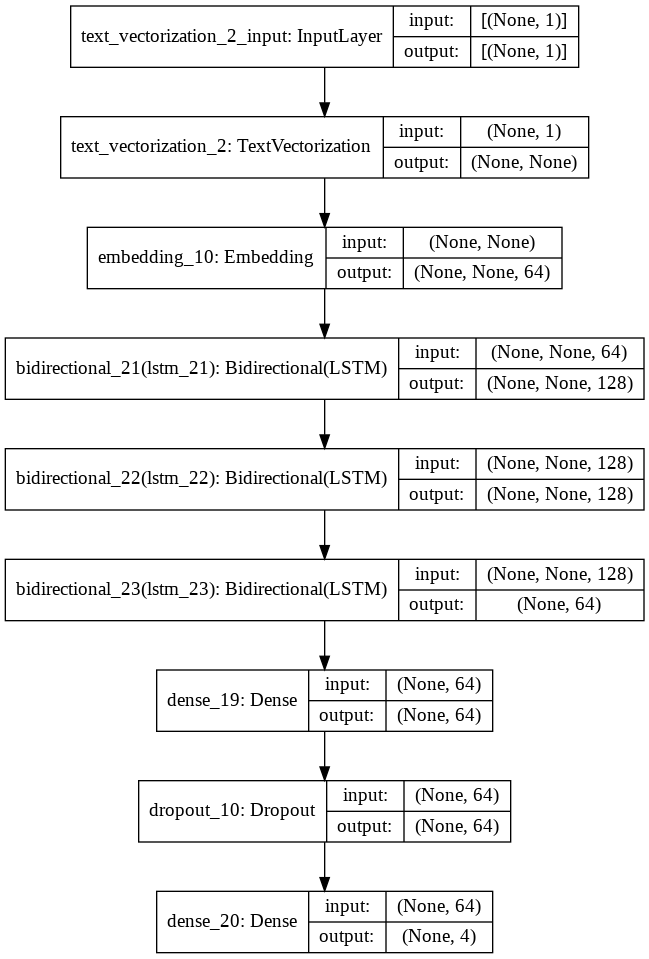

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


 ### Get the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
from tensorflow.keras import models

# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model2.layers]



In [ ]:
layer_outputs

[<KerasTensor: shape=(None, None) dtype=int64 (created by layer 'text_vectorization_2')>,
 <KerasTensor: shape=(None, None, 64) dtype=float32 (created by layer 'embedding_10')>,
 <KerasTensor: shape=(None, None, 128) dtype=float32 (created by layer 'bidirectional_21')>,
 <KerasTensor: shape=(None, None, 128) dtype=float32 (created by layer 'bidirectional_22')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional_23')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_19')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dropout_10')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_20')>]

In [ ]:
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)



ValueError: ignored

In [ ]:
print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(train_dataset)
hidden_layer_activation = activations[1]
output_layer_activations = activations[2]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

In [ ]:
output_layer_activations.shape

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

 ### Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

### Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
activation_df.shape

In [ ]:
N=55000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

In [ ]:
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
data_subset = activation_df_subset[features].values
data_subset.shape

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [ ]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

In [ ]:
x_train = x_train[5000:]
x_train.shape

In [ ]:
y_train = y_train[5000:]
y_train.shape

In [ ]:
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_train, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.title('Experiment 4: Visualizing Activation Values of 128 node model using t-DSNE')
plt.savefig('Experiment_4')
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/Holst_Assignment_A_3_NLP_Part_2.ipynb

[NbConvertApp] Converting notebook /content/Holst_Assignment_A_3_NLP_Part_2.ipynb to html
[NbConvertApp] Writing 3169729 bytes to /content/Holst_Assignment_A_3_NLP_Part_2.html
